# 6 Translation

Sure, I'll break down the Stata script into smaller code blocks with notes so you can run them separately in a Jupyter Notebook with the Stata kernel.

### Block 1: Setup and Logging

In [125]:
import logging

# Close any existing log files
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)



### Block 2: Define Globals

In [126]:
# Set global variables for the repository URL and local directory path
repo = "https://github.com/muzaale/forum/raw/main/"
dir = "~/documents/melody/local"



### Block 3: Load Data


### Block 4: Initial Data Exploration

In [127]:
import logging
import pandas as pd
import os

# Open a new log file to record the output
logging.basicConfig(filename='jamascript.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Log the start of the logging process
logging.info('Starting log file')

# Define the local directory and file name
local_dir = os.path.expanduser("~/documents/melody/local")
file_name = "esrdRisk_t02tT.csv"
file_path = os.path.join(local_dir, file_name)

# Check if the file exists locally
if os.path.isfile(file_path):
    try:
        data = pd.read_csv(file_path)
        logging.info('Dataset loaded successfully from local file')
    except Exception as e:
        logging.error(f"Failed to load dataset from local file: {e}")
        print(f"Failed to load dataset from local file: {e}")
        data = None
else:
    logging.error(f"File not found: {file_path}")
    print(f"File not found: {file_path}")
    data = None

if data is not None:
    # Display the distribution of the 'donor' variable
    donor_distribution = data['donor'].value_counts()
    print("Distribution of 'donor' variable:")
    print(donor_distribution)

    # Describe the 'rSMGJcEdF_d' variable
    codebook = data['rSMGJcEdF_d'].describe()
    print("\nCodebook for 'rSMGJcEdF_d' variable:")
    print(codebook)

    # Generate a new variable 'entry' based on the 'rSMGJcEdF_t0' variable
    data['entry'] = data['rSMGJcEdF_t0']

    # Logging the creation of the new variable
    logging.info("New variable 'entry' created based on 'rSMGJcEdF_t0'")
else:
    print("Dataset could not be loaded.")


Distribution of 'donor' variable:
donor
Donor                   96217
HealthyNondonor          9364
NotSoHealthyNondonor     8076
Name: count, dtype: int64

Codebook for 'rSMGJcEdF_d' variable:
count       113657
unique           3
top       Censored
freq        108448
Name: rSMGJcEdF_d, dtype: object


/var/folders/z3/nwmg00j178vfczmb9nk9487h0000gn/T/ipykernel_44009/3367355977.py:19: DtypeWarning: Columns (1,2,19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)



### Block 5: Data Cleaning and Adjustment

In [119]:
import pandas as pd

# Assuming 'data' is the DataFrame loaded previously

def codebook(df, column_name):
    column = df[column_name]
    summary = column.describe()
    value_counts = column.value_counts()
    
    # Display basic statistics
    print(f"Codebook for '{column_name}' variable:")
    print(summary)
    
    # Display value counts
    print("\nValue counts:")
    print(value_counts)
    
    # Display additional statistics if the column is numeric
    if pd.api.types.is_numeric_dtype(column):
        print("\nAdditional statistics:")
        print(f"Range: {column.min()} to {column.max()}")
        print(f"Unique values: {column.nunique()}")
        print(f"Missing values: {column.isna().sum()}")
    else:
        print("\nAdditional statistics are not applicable for non-numeric data types.")

# Generate the codebook for the 'donor' variable
codebook(data, 'donor')


Codebook for 'donor' variable:
count     113657
unique         3
top        Donor
freq       96217
Name: donor, dtype: object

Value counts:
donor
Donor                   96217
HealthyNondonor          9364
NotSoHealthyNondonor     8076
Name: count, dtype: int64

Additional statistics are not applicable for non-numeric data types.


This is messing up the dataset

```
import pandas as pd
import logging

# Assuming 'data' is the DataFrame loaded previously

# Ensure the date columns are in datetime format
data['rSMGJcEdF_tT'] = pd.to_datetime(data['rSMGJcEdF_tT'], format='%d%b%Y', errors='coerce')
data['entry'] = pd.to_datetime(data['entry'], format='%d%b%Y', errors='coerce')

# Define the critical dates
date_2011 = pd.to_datetime('2011-12-31')
date_1994 = pd.to_datetime('1994-01-01')

# Log the start of the adjustment process
logging.info("Starting the adjustment process for linkage dates")

# Linkage for donors after 2011 is untrustworthy
data.loc[(data['rSMGJcEdF_tT'] > date_2011) & (data['donor'] == 1), 'rSMGJcEdF_d'] = 0
data.loc[(data['rSMGJcEdF_tT'] > date_2011) & (data['donor'] == 1), 'rSMGJcEdF_tT'] = date_2011

# Linkage before 1994 is untrustworthy
data.loc[(data['entry'] < date_1994) & (data['rSMGJcEdF_tT'] > date_1994) & (data['donor'] == 1), 'entry'] = date_1994

# Log the completion of the replacement process
logging.info("Linkage for dates after 2011 and before 1994 adjusted successfully")

```


### Block 6: Mortality Analysis Setup

/var/folders/z3/nwmg00j178vfczmb9nk9487h0000gn/T/ipykernel_44009/3613857153.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


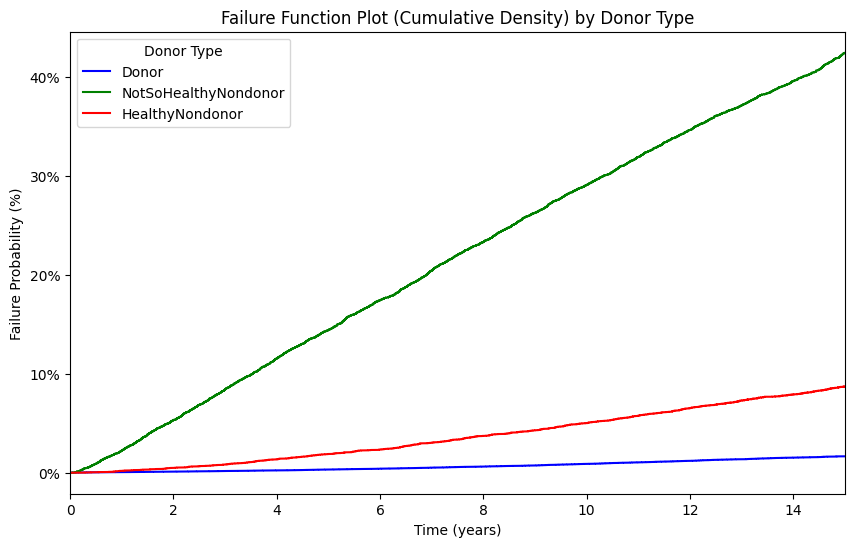

In [130]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assuming 'data' is already the DataFrame loaded previously

# Set the event indicator based on 'Died'
data['event'] = (data['rSMGJcEdF_d'] == 'Died').astype(int)

# Ensure date columns are in datetime format
data['rSMGJcEdF_tT'] = pd.to_datetime(data['rSMGJcEdF_tT'], errors='coerce')
data['rSMGJcEdF_t0'] = pd.to_datetime(data['rSMGJcEdF_t0'], errors='coerce')
data['entry'] = data['rSMGJcEdF_t0']  # Use _t0 as entry

# Calculate the duration from origin to the event or censoring in years
data['duration'] = (data['rSMGJcEdF_tT'] - data['rSMGJcEdF_t0']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

# Calculate the entry duration
data['entry_duration'] = (data['entry'] - data['rSMGJcEdF_t0']).dt.total_seconds() / (365.25 * 24 * 60 * 60)
data['entry_duration'] = data['entry_duration'].fillna(0)  # Ensure non-donor entries are set to 0

# Ensure all durations are non-negative and valid
data = data[(data['duration'] >= 0) & (data['entry_duration'] >= 0)]

# Initialize the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Plot setup
plt.figure(figsize=(10, 6))

# Unique donor values
donor_values = data['donor'].unique()

# Colors for each donor type
colors = ['blue', 'green', 'red']

# Overlay plots for different donor values
for donor, color in zip(donor_values, colors):
    kmf.fit(durations=data[data['donor'] == donor]['duration'],
            event_observed=data[data['donor'] == donor]['event'],
            entry=data[data['donor'] == donor]['entry_duration'],
            label=donor)
    ax = kmf.plot_cumulative_density(ci_show=False, color=color)

# Cut off the plot at 15 years
plt.xlim(0, 15)

# Convert y-axis to percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Labels and title
plt.xlabel("Time (years)")
plt.ylabel("Failure Probability (%)")
plt.title("Failure Function Plot (Cumulative Density) by Donor Type")
plt.legend(title="Donor Type")

# Optional: Display the plot (depends on your environment)
plt.show()



### Block 7: Generate Kaplan-Meier Estimates

In [132]:
import pandas as pd
from lifelines import KaplanMeierFitter

# Assuming 'data' is already the DataFrame loaded previously

# Set the event indicator based on 'Died'
data['event'] = (data['rSMGJcEdF_d'] == 'Died').astype(int)

# Ensure date columns are in datetime format
data['rSMGJcEdF_tT'] = pd.to_datetime(data['rSMGJcEdF_tT'], errors='coerce')
data['rSMGJcEdF_t0'] = pd.to_datetime(data['rSMGJcEdF_t0'], errors='coerce')
data['entry'] = data['rSMGJcEdF_t0']  # Use _t0 as entry

# Calculate the duration from origin to the event or censoring in years
data['duration'] = (data['rSMGJcEdF_tT'] - data['rSMGJcEdF_t0']).dt.total_seconds() / (365.25 * 24 * 60 * 60)

# Calculate the entry duration
data['entry_duration'] = (data['entry'] - data['rSMGJcEdF_t0']).dt.total_seconds() / (365.25 * 24 * 60 * 60)
data['entry_duration'] = data['entry_duration'].fillna(0)  # Ensure non-donor entries are set to 0

# Ensure all durations are non-negative and valid
data = data[(data['duration'] >= 0) & (data['entry_duration'] >= 0)]

# Initialize the KaplanMeierFitter
kmf = KaplanMeierFitter()

# Time points at which we want to extract survival probabilities
time_points = [5, 12, 15]

# Dictionary to hold the results
results = []

# Fit the model for each donor type and extract the survival probabilities
for donor in data['donor'].unique():
    kmf.fit(durations=data[data['donor'] == donor]['duration'],
            event_observed=data[data['donor'] == donor]['event'],
            entry=data[data['donor'] == donor]['entry_duration'],
            label=donor)
    
    for time in time_points:
        survival_prob = kmf.survival_function_at_times(time).values[0]
        results.append({
            'donor': donor,
            'time': time,
            'survival_probability': survival_prob,
            'failure_probability': 1 - survival_prob
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('km_results.csv', index=False)

# Display the results
print(results_df)


                  donor  time  survival_probability  failure_probability
0                 Donor     5              0.996751             0.003249
1                 Donor    12              0.988017             0.011983
2                 Donor    15              0.983427             0.016573
3  NotSoHealthyNondonor     5              0.855844             0.144156
4  NotSoHealthyNondonor    12              0.653661             0.346339
5  NotSoHealthyNondonor    15              0.575531             0.424469
6       HealthyNondonor     5              0.981093             0.018907
7       HealthyNondonor    12              0.934715             0.065285
8       HealthyNondonor    15              0.912715             0.087285


Only the donor results match [Segev, JAMA, 2010](https://abikesa.github.io/flow/_downloads/57876abeb3d25f47b41ed9b178f3d2c7/jamascript-m.pdf) p. 961. The nondonors here are unmatched and so do not yield the same estimates from this paper

A webApp is quick way to approximate these findings using the base-case of the "typical" donor as per Table 1, also on page 961. Namely, 40yo white female with some college education, BMI=28, SBP=120, no hypertension, no history of smoking cigarettes, creatinine 0.9 mg/dL, and eGFR 100 mL/min 

### Block 8: Summarize Failure Rates

### Block 9: Kaplan-Meier Survival Plot


### Block 11: Save Processed Data

 
### Block 12: Cox Proportional Hazards Model

In [134]:
import pandas as pd

# Assuming 'data' is already the DataFrame loaded previously

# Check for constant variables
constant_columns = [col for col in data.columns if data[col].nunique() <= 1]
print("Constant columns:", constant_columns)


Constant columns: ['_st', '_t0', 'entry_duration']


In [135]:
import pandas as pd
from lifelines import CoxPHFitter

# Ensure 'donor' is a categorical variable
data['donor'] = data['donor'].astype('category')

# Select necessary columns
data = data[['duration', 'event', 'donor']]

# Remove constant columns if any
constant_columns = [col for col in data.columns if data[col].nunique() <= 1]
data = data.drop(columns=constant_columns)

print("Constant columns removed:", constant_columns)


Constant columns removed: []


In [136]:
data.head()

,duration,event,donor
0,13.859001,0,Donor
1,9.409993,0,Donor
2,8.752909,0,Donor
3,8.273785,0,Donor
4,14.398357,0,Donor


In [140]:
import pandas as pd

# Load the data
file_path = '~/documents/melody/local/esrdRisk_t02tT.csv'  # Adjust the file path as needed
data = pd.read_csv(file_path)

# Check the first few rows and the column names
print(data.head())
print(data.columns)


   pers_id   don_id don_yearcat  don_age don_agecat don_female don_race_ethn  \
0  5005738  AAEN566   1998-2001       44      40-49     Female   White/Other   
1  4973528   ZIF796   2002-2005       47      40-49     Female   White/Other   
2  4961779   ZFV631   2002-2005       38      18-39     Female      Hispanic   
3  4961603   ZFN933   2006-2009       38      18-39       Male      Hispanic   
4  4949318   ZCU948   1998-2001       18      18-39     Female   White/Other   

    don_educat don_hyperten  don_smoke  ...  rSMGJcEdF_t rSMGJcEdF_x  age_t0  \
0          NaN   No History     Smoker  ...    11.192334         rSM      44   
1  <HighSchool          NaN  NoHistory  ...     6.743327         rSM      47   
2  <HighSchool   No History  NoHistory  ...     6.086242         rSM      38   
3  <HighSchool   No History  NoHistory  ...     5.607119         rSM      38   
4          NaN   No History  NoHistory  ...    11.731690         rSM      18   

      age_tT  female race  _st _d     

/var/folders/z3/nwmg00j178vfczmb9nk9487h0000gn/T/ipykernel_44009/1876344631.py:5: DtypeWarning: Columns (1,2,19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [144]:
import pandas as pd
from lifelines import CoxPHFitter

# Assuming 'data' is already the DataFrame loaded previously and necessary preprocessing is done

# Ensure 'donor' is a categorical variable
data['donor'] = data['donor'].astype('category')

# Fit a Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(data, duration_col='duration', event_col='event', formula="C(donor)")

# Extract the summary and relevant coefficients
summary = cph.summary

# Filter only relevant columns
coefficients = summary.loc[:, ['coef', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# Rename the rows for clarity
coefficients.index = ['HealthyNondonor vs Donor', 'NotSoHealthyNondonor vs Donor']

# Display the simplified results
print("Coefficients and Hazard Ratios Relative to Baseline (Donor):")
print(coefficients)


Coefficients and Hazard Ratios Relative to Baseline (Donor):
                                   coef  exp(coef)  exp(coef) lower 95%  \
HealthyNondonor vs Donor      -0.286770   0.750684             0.447060   
NotSoHealthyNondonor vs Donor  2.359067  10.581077             8.187331   

                               exp(coef) upper 95%  
HealthyNondonor vs Donor                  1.260518  
NotSoHealthyNondonor vs Donor            13.674688  


In [145]:
import pandas as pd
from lifelines import CoxPHFitter

# Assuming 'data' is already the DataFrame loaded previously and necessary preprocessing is done

# Ensure 'donor' is a categorical variable
data['donor'] = data['donor'].astype('category')

# Fit a Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(data, duration_col='duration', event_col='event', formula="C(donor)")

# Extract the summary and relevant coefficients
summary = cph.summary

# Filter only relevant columns
coefficients = summary.loc[:, ['coef', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]

# Rename the rows for clarity
coefficients.index = ['HealthyNondonor vs Donor', 'NotSoHealthyNondonor vs Donor']

# Display the simplified results
print("Coefficients and Hazard Ratios Relative to Baseline (Donor):")
print(coefficients)

# Compute hazard ratios
hazard_ratios = coefficients[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%']]
hazard_ratios.columns = ['Hazard Ratio', 'Lower 95% CI', 'Upper 95% CI']

print("\nHazard Ratios Relative to Baseline (Donor):")
print(hazard_ratios)


Coefficients and Hazard Ratios Relative to Baseline (Donor):
                                   coef  exp(coef)  exp(coef) lower 95%  \
HealthyNondonor vs Donor      -0.286770   0.750684             0.447060   
NotSoHealthyNondonor vs Donor  2.359067  10.581077             8.187331   

                               exp(coef) upper 95%  
HealthyNondonor vs Donor                  1.260518  
NotSoHealthyNondonor vs Donor            13.674688  

Hazard Ratios Relative to Baseline (Donor):
                               Hazard Ratio  Lower 95% CI  Upper 95% CI
HealthyNondonor vs Donor           0.750684      0.447060      1.260518
NotSoHealthyNondonor vs Donor     10.581077      8.187331     13.674688




### Block 13: Save Baseline Survival and Coefficients

```stata
// Define matrix 'b' with model coefficients
matrix define b = e(b)

// Keep baseline survival estimates
keep s0 _t 

// Sort and list baseline survival estimates
sort _t s0
list in 1/10

// Save baseline survival estimates
save ${dir}/s0.dta, replace
export delimited using ${dir}/s0.csv, replace

// Save model coefficients
matrix beta = e(b)
svmat beta
keep beta*
drop if missing(beta1)
list 
save ${dir}/b.dta, replace
export delimited using ${dir}/b.csv, replace
```